In [118]:
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import numpy as np
import warnings
import json
warnings.simplefilter(action='ignore')

In [119]:
start1111 = 2023 # 回測是這個+1
end11111 = start1111-2
quadrant_class_start_date = pd.to_datetime(f"{end11111}-01-01")
start = quadrant_class_start_date-timedelta(days=90)
quadrant_class_end_date   = pd.to_datetime(f"{start1111}-12-31")
# 如果要測2020年全年的績效（用2019以前的數字 
# => quad_end   = 2020-12-31
# => quad_start = 2018-01-01

In [120]:
# 獲得分類所需資料期間： 2017-01-01 == 2021-12-31
# 往前outsample期間： 2022-01-01 == 2022-12-31

# signal_quadrant 所需期間：不限（甚至可以提前存起來）

'''
需要前五年數據得到股票分類 
需要前三年數據得到象限分類 2019-01-01 == 2021-12-31, 
    因為count_return的關係必須再有往前60個交易日的資料．
'''
with open(f"farrell_for{start1111+1}_top100_cluster9.json", "r") as f:
    data = json.load(f)

etf_list = data
def get_etf_list(etf_list):
    all_etf_list = []
    for etf in etf_list.values():
        all_etf_list.extend(etf)
    return all_etf_list
etfs = get_etf_list(etf_list)

In [121]:

def get_data_from_yfinance(pool: list, start="1980-01-01", end=datetime.now()) -> pd.DataFrame:
    df = yf.download(pool, start=start, end=end, ignore_tz=True, progress=False)
    Adj_rate = df['Adj Close']/df['Close']
    for column in ['Close', 'Open', 'High', 'Low']:
        df[column] *= Adj_rate
        df[column] = df[column].ffill()  # fill forward 
    return df.loc[:, (slice(None), pool)]['Close']  

def count_return(df_etfs,etf_list):
    df_etf = df_etfs[df_etfs.columns.intersection(etf_list)]
    df_etf['equal_weight_sum'] = df_etf.sum(axis=1)
    for etf in df_etf.columns:
        df_etf[str(etf)+'weight'] = df_etf[str(etf)]**2/df_etf['equal_weight_sum']
    df_etf['value_weight_sum'] =df_etf.iloc[:,(len(etf_list)+1):].sum(axis=1)
    df_etf['d_ew_return'] = df_etf['equal_weight_sum'].pct_change()
    df_etf['w_ew_return'] = df_etf['equal_weight_sum'].pct_change(periods=5)
    df_etf['m_ew_return'] = df_etf['equal_weight_sum'].pct_change(periods=20)
    df_etf['q_ew_return'] = df_etf['equal_weight_sum'].pct_change(periods=60)
    df_etf['d_vw_return'] = df_etf['value_weight_sum'].pct_change()
    df_etf['w_vw_return'] = df_etf['value_weight_sum'].pct_change(periods=5)
    df_etf['m_vw_return'] = df_etf['value_weight_sum'].pct_change(periods=20)
    df_etf['q_vw_return'] = df_etf['value_weight_sum'].pct_change(periods=60)
    df_etf.dropna(inplace=True)
    return df_etf

In [122]:
df_close = get_data_from_yfinance(etfs, start=start, end=quadrant_class_end_date)
df_close_dropna = df_close.dropna()
if len(df_close_dropna) == len(df_close):
    print("stock init date test passed")
    print(df_close.index[0])
else:
    print(f"one of the stocks' init date later than {quadrant_class_start_date}")


stock init date test passed
2020-10-05 00:00:00


In [123]:
returns_dict = {}
etf_names = list(etf_list.keys())

for etf_name in etf_names:
    returns_dict[etf_name] = count_return(df_close,etf_list[etf_name])

In [124]:
# jimmy
def get_quadrants_v2(short_period = 250, long_period=750 , start='2013-01-01', end=datetime.now()):

    '''
    回測改變short/long period
    '''
    # 大盤前三年累積報酬率(市場狀態)
    # twse_index = yf.download('^TWII',start="2000-06-15", end='2019-12-31')
    twse_index = yf.download('^SPX',start=start, end=end, progress=False)
    # print(len(twse_index[twse_index.index >= "2003-06-30"]))
    twse_index['Close_3y_b'] = twse_index['Close'].shift(long_period)
    twse_index['Close_1y_b'] = twse_index['Close'].shift(short_period)
    # twse_index['ret_3y'] = twse_index['Close']/twse_index['Close_3y_b'] - 1
    # twse_index['ret_1y'] = twse_index['Close']/twse_index['Close_1y_b'] - 1
    twse_index['pct_change'] = twse_index['Close'].pct_change()
    # twse_index['ret_cum_3y'] = (1+twse_index['pct_change']).rolling(window=750).agg(lambda x : x.prod()) -1
    twse_index['ret_3y'] = twse_index['pct_change'].rolling(long_period).sum()
    twse_index['ret_1y'] = twse_index['pct_change'].rolling(short_period).sum()
    twse_index['std_3y'] = twse_index['pct_change'].rolling(window=long_period).std()
    twse_index['std_1y'] = twse_index['pct_change'].rolling(window=short_period).std()
    twse_index['vol'] = twse_index['ret_1y'] - twse_index['ret_3y']
    # twse_index = twse_index[twse_index.index >= pd.to_datetime(start)+timedelta(days=365*3)]
    # print(len(twse_index))
    # twse_index.dropna(inplace=True)
    # 波動度
    cum_return_3Y = twse_index['ret_3y']
    volatility = twse_index['vol']
    
    
    quadrant = []

    for i in range(len(twse_index)):
        if cum_return_3Y[i]>0 and volatility[i]>0:
            quadrant.append(1)
        elif cum_return_3Y[i]<0 and volatility[i]>0:
            quadrant.append(2)
        elif cum_return_3Y[i]<0 and volatility[i]<0:
            quadrant.append(3)
        elif cum_return_3Y[i]>0 and volatility[i]<0:
            quadrant.append(4)
        else:
            quadrant.append(5)

    twse_index['signal'] = quadrant
    return twse_index


In [125]:
twse = get_quadrants_v2(short_period=20, long_period=60)
twse.dropna(inplace=True)
total_signals = {}
for i in range(1, 6):
    total_signals[f'total_signal_q{i}'] = twse[twse['signal'] == i].index

twse.signal.value_counts(), twse.index[0]


(signal
 4    1866
 2     435
 1     294
 3     209
 Name: count, dtype: int64,
 Timestamp('2013-04-01 00:00:00'))

In [126]:
def get_performence(returns_dict, date_list,freq='d'):
    etf_perfs_dict = {}
    etf_names = list(returns_dict.keys())
    for etf_name in etf_names:
        etf = returns_dict[etf_name]
        etf_perfs_dict[etf_name] = [etf[etf.index.isin(date_list)][f'{freq}_ew_return'].mean(),etf[etf.index.isin(date_list)][f'{freq}_ew_return'].sem(),etf[etf.index.isin(date_list)][f'{freq}_ew_return'].median(),
                    etf[etf.index.isin(date_list)][f'{freq}_vw_return'].mean(),etf[etf.index.isin(date_list)][f'{freq}_vw_return'].sem(),etf[etf.index.isin(date_list)][f'{freq}_vw_return'].median()]
    
    etf_perfs = pd.DataFrame(etf_perfs_dict, index = ['equal_weight_mean','equal_weight_se','equal_weight_median','value_weight_mean','value_weight_se','value_weight_median']).T
    return etf_perfs

def strategy(df_perf, benchmark='value_weight_mean'):
    buy_etf = df_perf[benchmark].idxmax()
    sell_etf = df_perf[benchmark].idxmin()
    return [buy_etf, sell_etf]

In [138]:
get_performence(returns_dict, q1_dt, freq)

,equal_weight_mean,equal_weight_se,equal_weight_median,value_weight_mean,value_weight_se,value_weight_median
class0,0.001312,0.000635,0.001433,0.001290,0.000636,0.001373
class1,0.004047,0.002019,0.002687,0.003882,0.002006,0.002373
class2,0.003431,0.001245,0.003687,0.003451,0.001233,0.003419
class3,0.003871,0.001807,0.001444,0.003892,0.001824,0.001475
class4,0.000667,0.001665,0.000175,0.000649,0.001655,0.000419
class5,0.002623,0.001227,0.002094,0.002683,0.001237,0.002255
class6,-0.000898,0.002454,0.001105,-0.001575,0.002857,0.000582
class7,0.002196,0.000899,0.002371,0.002249,0.000925,0.002238
class8,0.002885,0.001058,0.002704,0.002925,0.001075,0.002625


In [127]:
### 用當下過去三年數據算分類
# parameter
year = 3
backtest_period = 250*year
# 多久檢查一次分類(和多久換股一次不一樣)
'''
# by day
iteration = 1

# by week
iteration = 5

# by 4 week
iteration = 20

# by quarter(12 weeks)
iteration = 60
'''
iteration = 1
freq = "d"
total = {}
iter_datetime = twse.index[(twse.index >= quadrant_class_end_date) & (twse.index <= quadrant_class_end_date+timedelta(days=365))]
list_4q = [] # 紀錄每次iteration分類，一樣的話就忽略
a = ['equal_weight_mean','equal_weight_median','value_weight_mean','value_weight_median']
b = ['equal_weight_median','value_weight_median']
for benchmark in a:
    holdings = {} # 紀錄 {datetime: list_4q}，包含 list_4q 所有變動，datetime是分類生效的日期，用datetime的前一個交易日的數據算的

    for i in range(int((len(iter_datetime))/iteration)):
        max_date = iter_datetime[i*iteration]
        min_date = pd.to_datetime(max_date) - timedelta(days=365*3)
        
        q1_dt = [date for date in list(total_signals.values())[0] if date < max_date and date >= min_date]
        q2_dt = [date for date in list(total_signals.values())[1] if date < max_date and date >= min_date]
        q3_dt = [date for date in list(total_signals.values())[2] if date < max_date and date >= min_date]
        q4_dt = [date for date in list(total_signals.values())[3] if date < max_date and date >= min_date]
        # print(max_date, min_date)
        # 用過去數據，算 max_date 當天的策略
        etf_q1 = strategy(get_performence(returns_dict, q1_dt, freq),benchmark=benchmark)
        etf_q2 = strategy(get_performence(returns_dict, q2_dt, freq),benchmark=benchmark)
        etf_q3 = strategy(get_performence(returns_dict, q3_dt, freq),benchmark=benchmark)
        etf_q4 = strategy(get_performence(returns_dict, q4_dt, freq),benchmark=benchmark)
        list_ = [etf_q1,etf_q2, etf_q3, etf_q4]
        if list_4q != list_:
            list_4q = list_
            print(max_date, list_4q)
        holdings[max_date.strftime("%Y-%m-%d")] = list_4q
    total[benchmark] = holdings

class_json = f"for{start1111+1}_quads_F100C9BM2_freq_{freq}.json"
with open(class_json, "w") as f:
    json.dump(total, f, indent=4)

2024-01-02 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class4', 'class0']]


2024-01-16 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class4', 'class7']]
2024-02-20 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class3', 'class7']]
2024-03-01 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class3', 'class5']]
2024-03-04 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class3', 'class7']]
2024-03-05 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class3', 'class8']]
2024-03-08 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class3', 'class7']]
2024-04-08 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class4', 'class7']]
2024-04-22 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class4', 'class8']]
2024-04-29 00:00:00 [['class1', 'class6'], ['class8', 'class3'], ['class4', 'class2'], ['class3', 'class8']]
2024-04-30 00:00:00

In [128]:

# ETF1:國內成分證券 ETF
def getNavSeries(df_now_for_nav, weighting, nav_current = 1, short=False):
    if short:
        df2 = (1 - df_now_for_nav.pct_change()).cumprod()
    else:

        df2 = (1 + df_now_for_nav.pct_change()).cumprod()
    # print(df2)
    df3 = df2.fillna(1)
    df4 = df3*nav_current
    nav_series = np.sum(df4 * weighting, axis=1)
    nav = nav_series.iloc[-1]
    return nav_series, nav

def subplots_x_y(total):
    x = np.sqrt(total)
    y = total/x
    if y == np.round(y):
        y = int(y)
    else:
        y = int(y) + 1
    if x == np.round(x):
        x = int(x) + 1
    else:
        x = int(x) + 1
    return x, y

(Timestamp('2020-09-19 00:00:00'), Timestamp('2024-05-17 00:00:00'))

In [ ]:
twse['signal'] = twse['signal'].shift(1)

同ETF pool，不同benckmark

[*********************100%%**********************]  1 of 1 completed


['2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-16', '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22', '2024-01-23', '2024-01-24', '2024-01-25', '2024-01-26', '2024-01-29', '2024-01-30', '2024-01-31', '2024-02-01', '2024-02-02', '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08', '2024-02-09', '2024-02-12', '2024-02-13', '2024-02-14', '2024-02-15', '2024-02-16', '2024-02-20', '2024-02-21', '2024-02-22', '2024-02-23', '2024-02-26', '2024-02-27', '2024-02-28', '2024-02-29', '2024-03-01', '2024-03-04', '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-11', '2024-03-12', '2024-03-13', '2024-03-14', '2024-03-15', '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21', '2024-03-22', '2024-03-25', '2024-03-26', '2024-03-27', '2024-03-28', '2024-04-01', '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-08', '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12', '2024

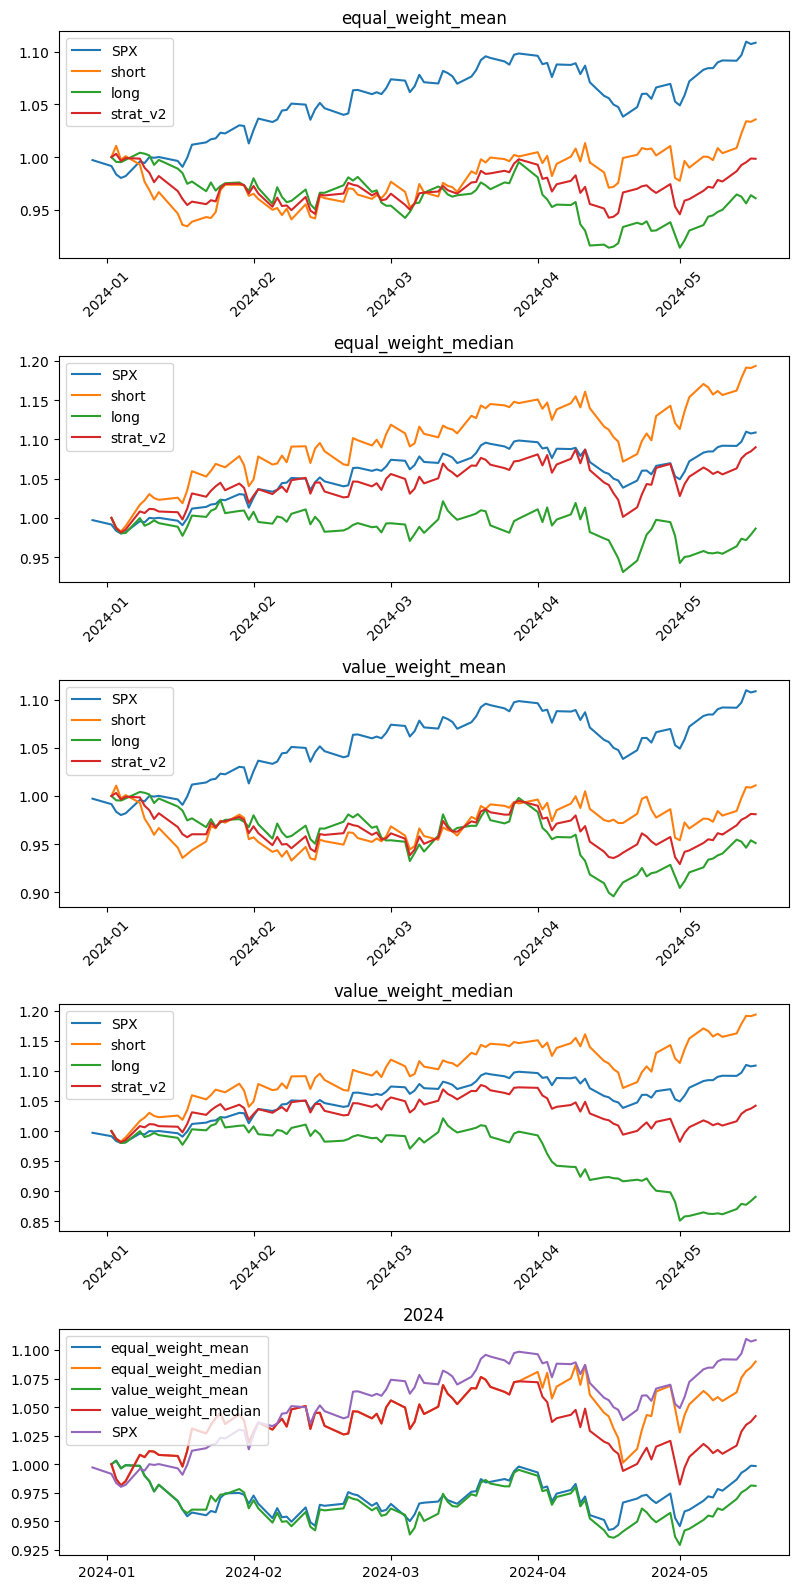

In [137]:

with open(class_json, "r") as f:
    list_strat = json.load(f)
start = pd.to_datetime(list(list_strat[list(list_strat.keys())[0]].keys())[0]) - timedelta(days=1200)
end = pd.to_datetime(list(list_strat[list(list_strat.keys())[0]].keys())[-1])

fig, ax = plt.subplots(5, 1, figsize=(8, 16))

# monthly: interval=20
interval = 10
fee = 0.0
df_close = get_data_from_yfinance(etfs, start=quadrant_class_end_date-timedelta(days=3), end=quadrant_class_end_date+timedelta(days=365))


with open(class_json, "r") as f:
    benchmark_dicts = json.load(f)
benchmarks = list(benchmark_dicts.keys())
spx_close = yf.download("^SPX", start=quadrant_class_end_date-timedelta(days=3), end=quadrant_class_end_date+timedelta(days=365))['Adj Close']

for benchmark_iter, benchmark in enumerate(benchmarks):

    list_da = []
    
    '''
    params init
    '''
    trade_list_buy = {}
    trade_list_sell = {}
    nav_all = pd.Series()
    nav_current = 1

    nav_all_short = pd.Series()
    nav_current_short = 1
    sell_current_list = []
    buy_current_list = []
    list_strat = benchmark_dicts[benchmark]
    print(list(list_strat.keys()))
    test_start = list(list_strat.keys())[0]
    test_da = df_close[df_close.index >= test_start].index[::interval]
    start = pd.to_datetime(list(list_strat.keys())[0]) - timedelta(days=1200)
    end = pd.to_datetime(list(list_strat.keys())[-1])

    for index, da in enumerate(test_da):
        signal = int(twse[twse.index == da.strftime("%Y-%m-%d")].signal[0])
        buy_sell = list_strat[da.strftime("%Y-%m-%d")]
        buy_cls = etf_list[buy_sell[signal-1][1]] # buy ETFs
        sell_cls = etf_list[buy_sell[signal-1][0]] # sell ETFs
        
        if buy_current_list != buy_cls:
            fee_long = fee
            buy_current_list = buy_cls
            trade_list_buy[da] = [signal, buy_sell[signal-1][0]]
        else:
            fee_long = 0
        if sell_current_list != sell_cls:
            fee_short = fee
            sell_current_list = sell_cls
            trade_list_sell[da] = [signal, buy_sell[signal-1][1]]
        else:
            fee_short = 0
            
        if index == len(test_da) - 1:
            nav_df = df_close[buy_cls][(df_close.index >= da) & (df_close.index <= da + timedelta(days=30))]
            
            nav_df_short = df_close[sell_cls][(df_close.index >= da) & (df_close.index <= da + timedelta(days=30))]
        else:
            nav_df = df_close[buy_cls][(df_close.index >= da) & (df_close.index <= test_da[index+1])]
            nav_df_short = df_close[sell_cls][(df_close.index >= da) & (df_close.index <= test_da[index+1])]
        nav_df.dropna(axis=1, inplace=True)
        etf_objs = len(nav_df.columns)
        weighting = [1/etf_objs]*etf_objs
        nav_series, nav_current = getNavSeries(nav_df, weighting, nav_current)
        nav_series = nav_series * (1 - fee_long)
        nav_current = nav_current * (1 - fee_long)
        nav_all = pd.concat([nav_all, nav_series], axis=0)
        # ========================================

        nav_df_short.dropna(axis=1, inplace=True)
        etf_objs_short = len(nav_df_short.columns)
        weighting_short = [1/etf_objs_short]*etf_objs_short
        nav_series_short, nav_current_short = getNavSeries(nav_df_short, weighting_short, nav_current_short, short=True)
        nav_series_short = nav_series_short * (1 - fee_short)
        nav_current_short = nav_current_short * (1 - fee_short)
        nav_all_short = pd.concat([nav_all_short, nav_series_short], axis=0)
        # ========================================
    spx = (1+spx_close.pct_change()).cumprod()
    ax[benchmark_iter].plot(spx, label='SPX')
    ax[benchmark_iter].plot(nav_all_short, label='short')

    ax[benchmark_iter].tick_params(axis='x', rotation=45)
    ax[benchmark_iter].plot(nav_all, label='long')
    ax[benchmark_iter].set_title(benchmark)
    strat = (nav_all + nav_all_short)/2
    ax[benchmark_iter].plot(strat, label='strat_v2')
    ax[benchmark_iter].legend()

    ax[4].plot(strat, label=benchmark)
    for i in list(trade_list_sell.keys()):
        ax[benchmark_iter].axvline(i, color="b")

    for i in list(trade_list_buy.keys()):
        ax[benchmark_iter].axvline(i, color="r")
    print(benchmark, trade_list_buy)

ax[4].plot(spx, label='SPX')
ax[4].set_title(start1111+1)
ax[4].legend()

plt.tight_layout()

[*********************100%%**********************]  1 of 1 completed


['2020-12-31', '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-19', '2021-01-20', '2021-01-21', '2021-01-22', '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28', '2021-01-29', '2021-02-01', '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05', '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-16', '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05', '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18', '2021-03-19', '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26', '2021-03-29', '2021-03-30', '2021-03-31', '2021-04-01', '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08', '2021-04-09', '2021-04-12', '2021-04-13', '2021-04-14', '2021

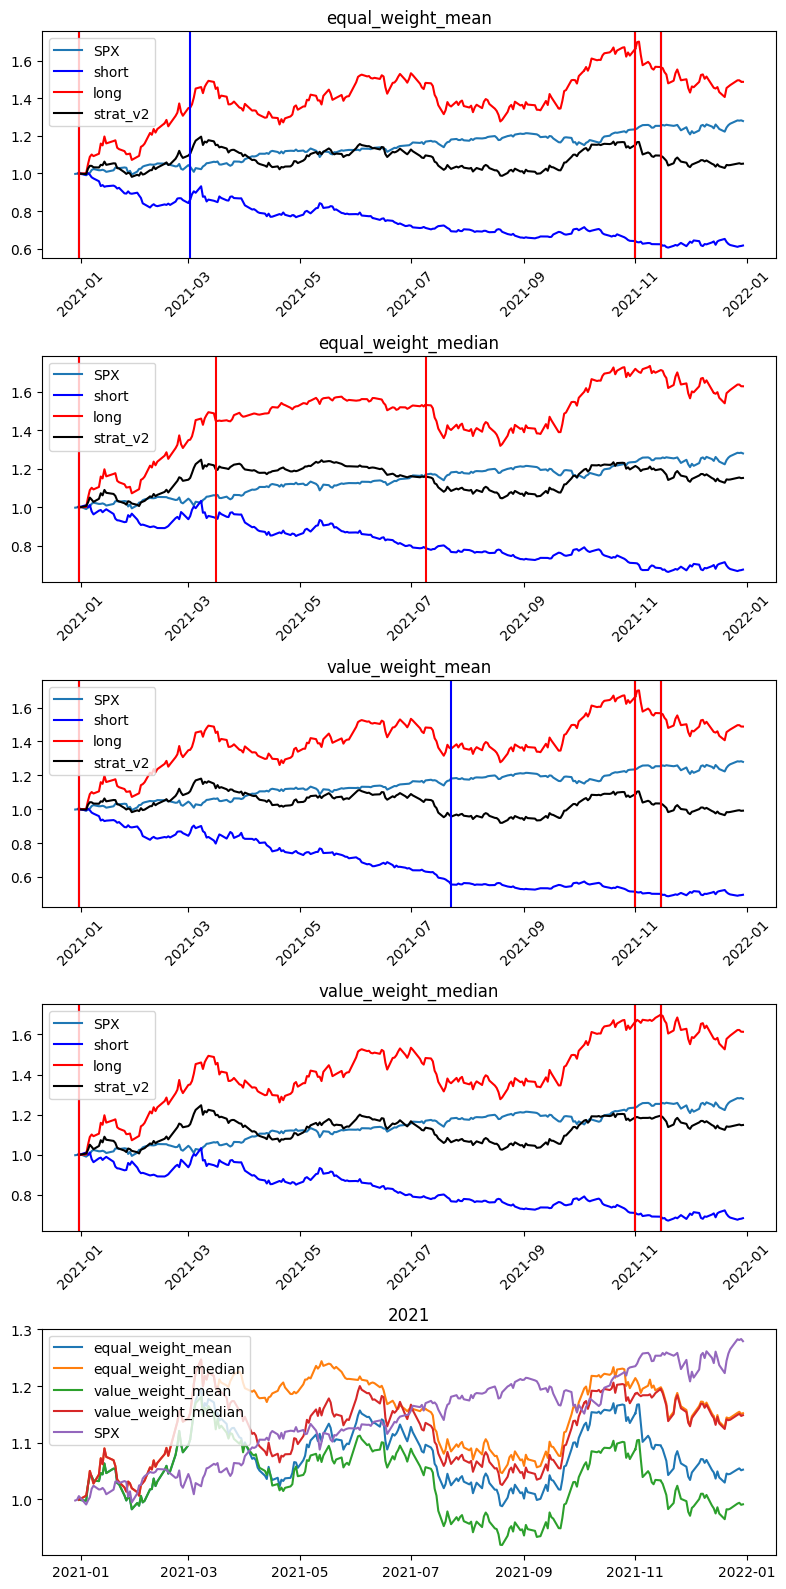

[*********************100%%**********************]  1 of 1 completed


['2021-12-31', '2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-18', '2022-01-19', '2022-01-20', '2022-01-21', '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28', '2022-01-31', '2022-02-01', '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-07', '2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11', '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18', '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25', '2022-02-28', '2022-03-01', '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10', '2022-03-11', '2022-03-14', '2022-03-15', '2022-03-16', '2022-03-17', '2022-03-18', '2022-03-21', '2022-03-22', '2022-03-23', '2022-03-24', '2022-03-25', '2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01', '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07', '2022-04-08', '2022-04-11', '2022-04-12', '2022

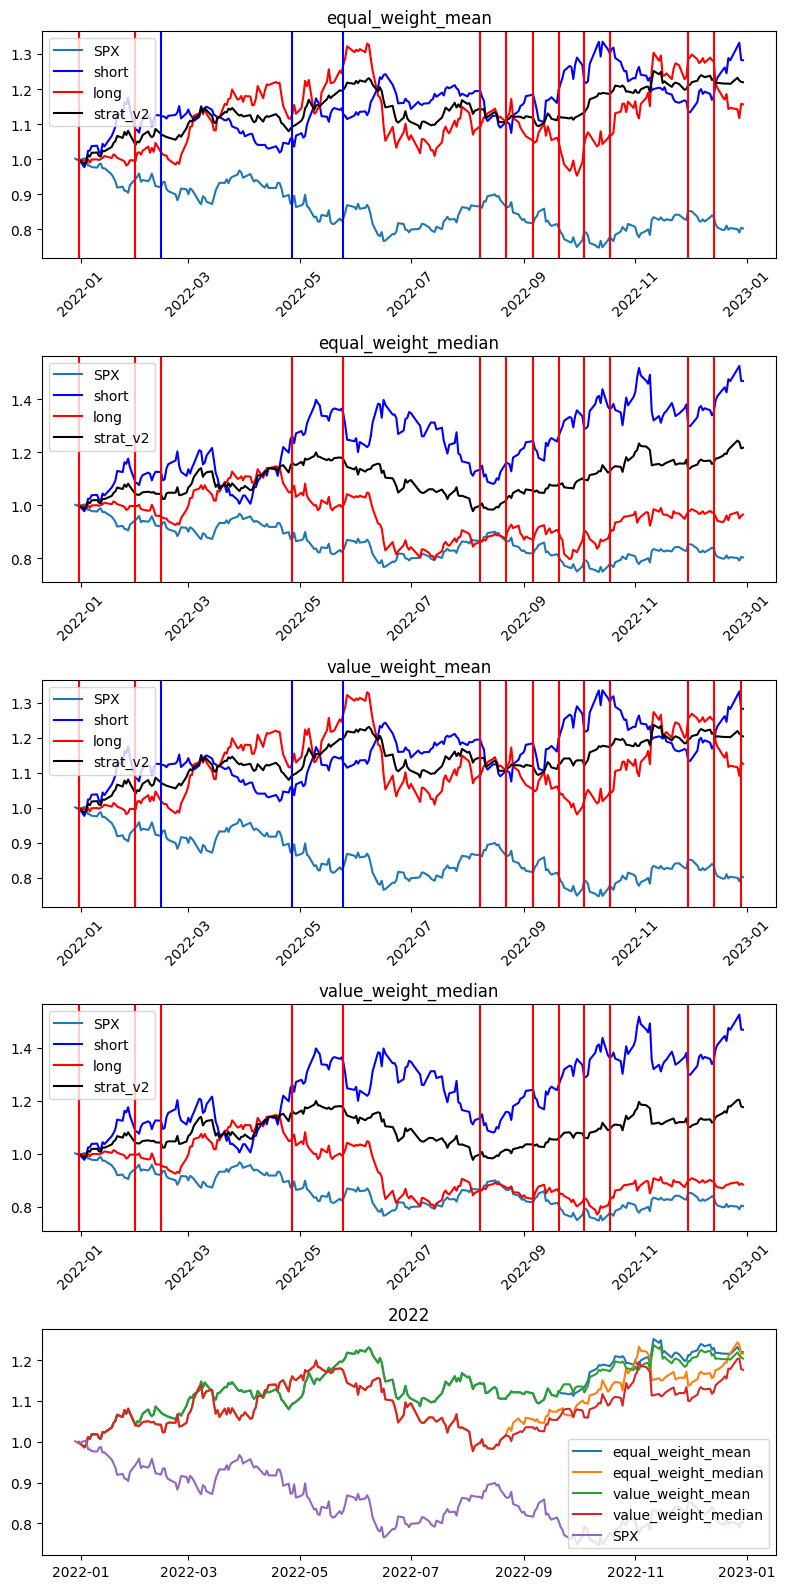

[*********************100%%**********************]  1 of 1 completed


['2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12', '2023-01-13', '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-20', '2023-01-23', '2023-01-24', '2023-01-25', '2023-01-26', '2023-01-27', '2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17', '2023-02-21', '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-27', '2023-02-28', '2023-03-01', '2023-03-02', '2023-03-03', '2023-03-06', '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-10', '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-20', '2023-03-21', '2023-03-22', '2023-03-23', '2023-03-24', '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30', '2023-03-31', '2023-04-03', '2023-04-04', '2023-04-05', '2023-04-06', '2023-04-10', '2023-04-11', '2023-04-12', '2023-04-13', '2023-04-14', '2023

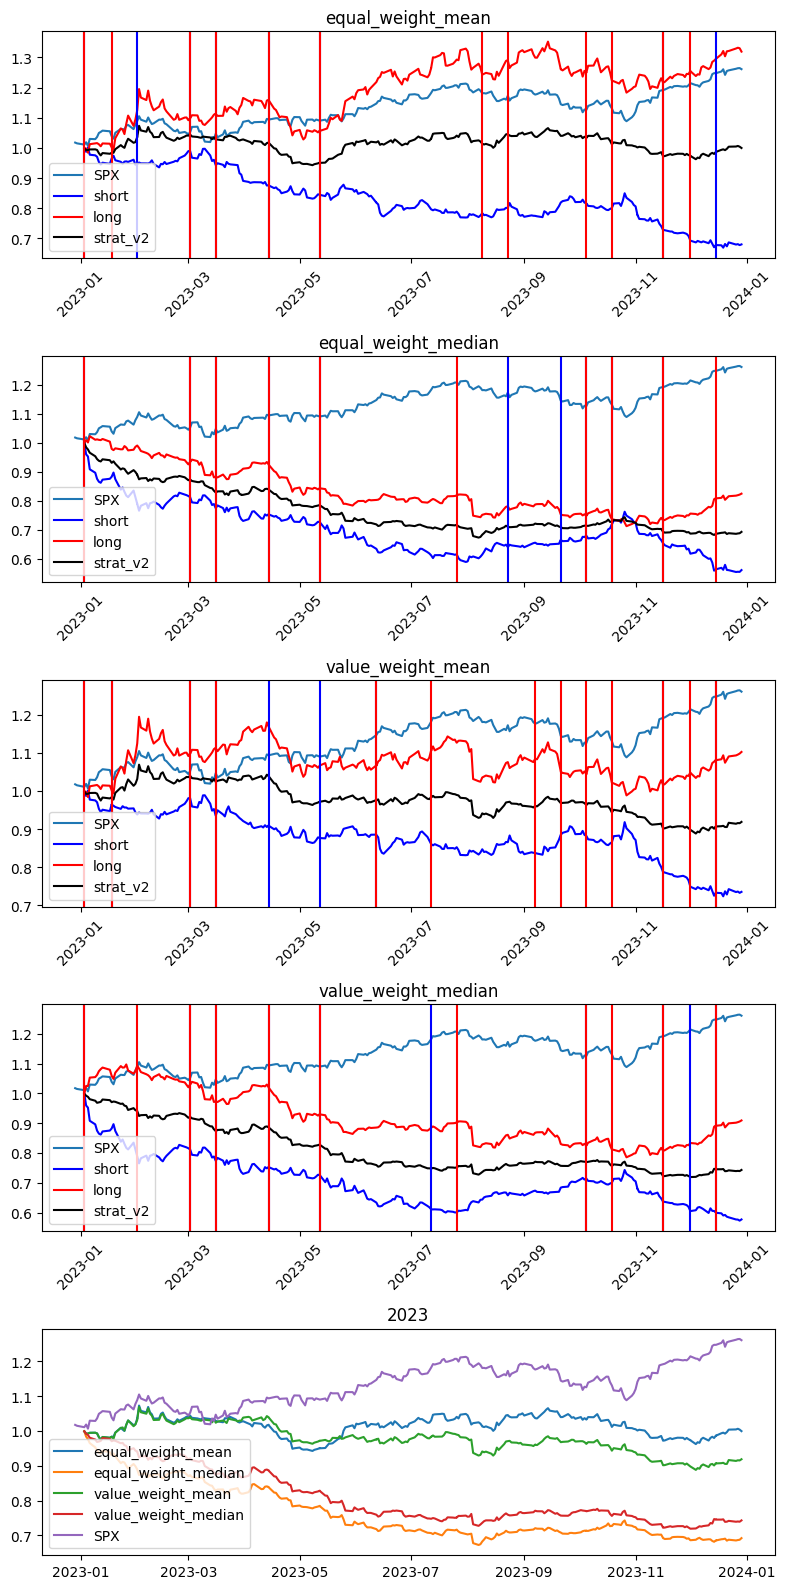

[*********************100%%**********************]  1 of 1 completed


['2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-16', '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22', '2024-01-23', '2024-01-24', '2024-01-25', '2024-01-26', '2024-01-29', '2024-01-30', '2024-01-31', '2024-02-01', '2024-02-02', '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08', '2024-02-09', '2024-02-12', '2024-02-13', '2024-02-14', '2024-02-15', '2024-02-16', '2024-02-20', '2024-02-21', '2024-02-22', '2024-02-23', '2024-02-26', '2024-02-27', '2024-02-28', '2024-02-29', '2024-03-01', '2024-03-04', '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-11', '2024-03-12', '2024-03-13', '2024-03-14', '2024-03-15', '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21', '2024-03-22', '2024-03-25', '2024-03-26', '2024-03-27', '2024-03-28', '2024-04-01', '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-08', '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12', '2024

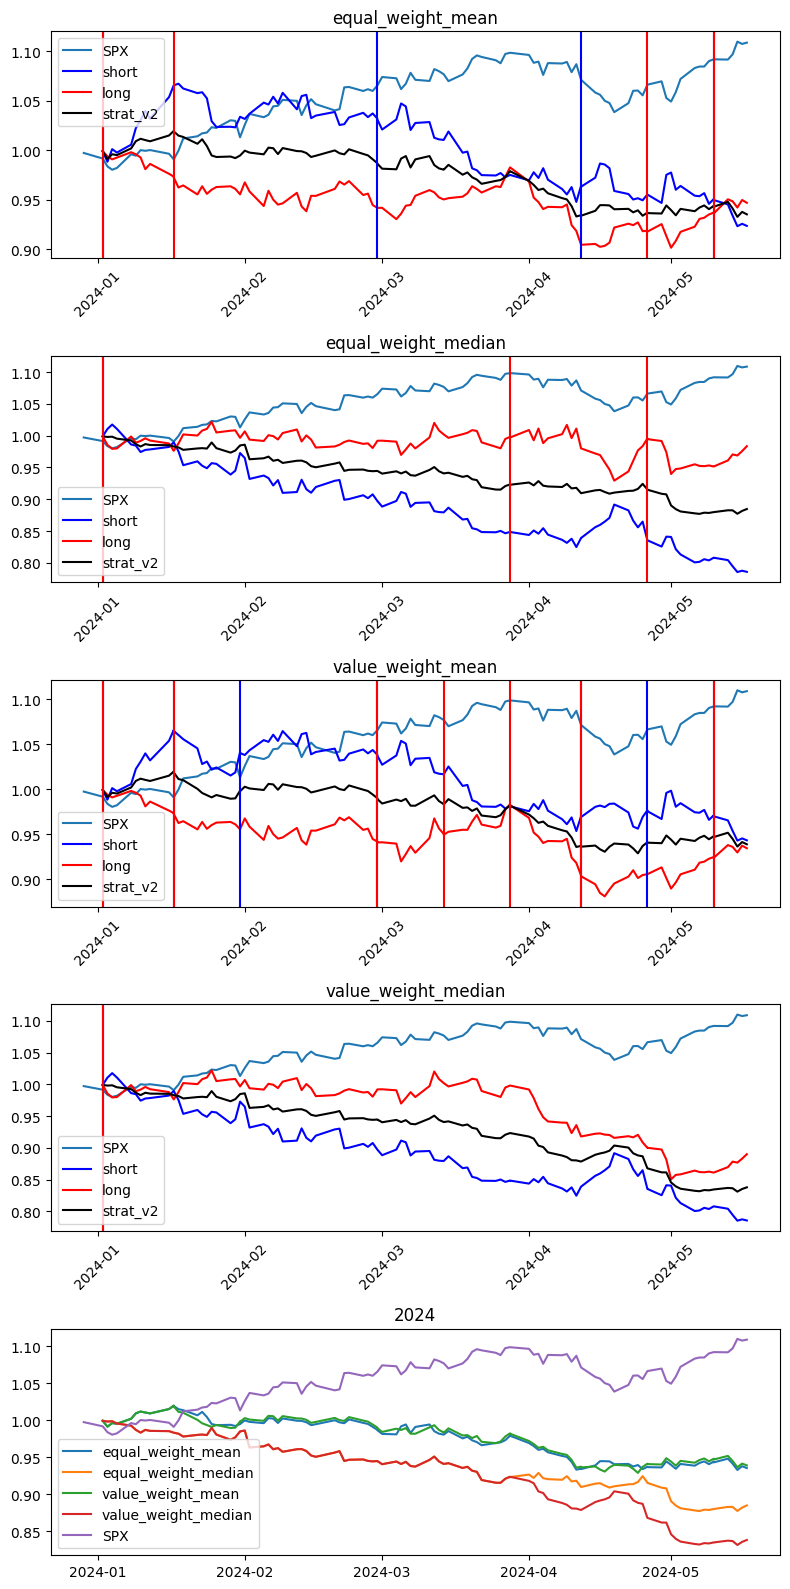

In [145]:
# 回測
stocks = 10
for start1111 in [2020, 2021, 2022, 2023]:

    class_json = f"for{start1111+1}_quads_F100C9BM2_freq_{freq}.json"
    quadrant_class_end_date   = pd.to_datetime(f"{start1111}-12-31")

    with open(class_json, "r") as f:
        list_strat = json.load(f)
    start = pd.to_datetime(list(list_strat[list(list_strat.keys())[0]].keys())[0]) - timedelta(days=1200)
    end = pd.to_datetime(list(list_strat[list(list_strat.keys())[0]].keys())[-1])

    fig, ax = plt.subplots(5, 1, figsize=(8, 16))

    # monthly: interval=20
    interval = 10
    fee = 0.001
    df_close = get_data_from_yfinance(etfs, start=quadrant_class_end_date-timedelta(days=3), end=quadrant_class_end_date+timedelta(days=365))


    with open(class_json, "r") as f:
        benchmark_dicts = json.load(f)
    benchmarks = list(benchmark_dicts.keys())
    spx_close = yf.download("^SPX", start=quadrant_class_end_date-timedelta(days=3), end=quadrant_class_end_date+timedelta(days=365))['Adj Close']

    for benchmark_iter, benchmark in enumerate(benchmarks):

        list_da = []
        
        '''
        params init
        '''
        trade_list_buy = {}
        trade_list_sell = {}
        nav_all = pd.Series()
        nav_current = 1

        nav_all_short = pd.Series()
        nav_current_short = 1
        sell_current_list = []
        buy_current_list = []
        list_strat = benchmark_dicts[benchmark]
        print(list(list_strat.keys()))
        test_start = list(list_strat.keys())[0]
        test_da = df_close[df_close.index >= test_start].index[::interval]
        start = pd.to_datetime(list(list_strat.keys())[0]) - timedelta(days=1200)
        end = pd.to_datetime(list(list_strat.keys())[-1])

        for index, da in enumerate(test_da):
            signal = int(twse[twse.index == da.strftime("%Y-%m-%d")].signal[0])
            buy_sell = list_strat[da.strftime("%Y-%m-%d")]
            buy_cls = etf_list[buy_sell[signal-1][1]][:stocks] # buy ETFs
            sell_cls = etf_list[buy_sell[signal-1][0]][:stocks] # sell ETFs
            
            if buy_current_list != buy_cls:
                fee_long = fee
                buy_current_list = buy_cls
                trade_list_buy[da] = [signal, buy_sell[signal-1][0]]
            else:
                fee_long = 0
            if sell_current_list != sell_cls:
                fee_short = fee
                sell_current_list = sell_cls
                trade_list_sell[da] = [signal, buy_sell[signal-1][1]]
            else:
                fee_short = 0
                
            if index == len(test_da) - 1:
                nav_df = df_close[buy_cls][(df_close.index >= da) & (df_close.index <= da + timedelta(days=30))]
                
                nav_df_short = df_close[sell_cls][(df_close.index >= da) & (df_close.index <= da + timedelta(days=30))]
            else:
                nav_df = df_close[buy_cls][(df_close.index >= da) & (df_close.index <= test_da[index+1])]
                nav_df_short = df_close[sell_cls][(df_close.index >= da) & (df_close.index <= test_da[index+1])]
            nav_df.dropna(axis=1, inplace=True)
            etf_objs = len(nav_df.columns)
            weighting = [1/etf_objs]*etf_objs
            nav_series, nav_current = getNavSeries(nav_df, weighting, nav_current)
            nav_series = nav_series * (1 - fee_long)
            nav_current = nav_current * (1 - fee_long)
            nav_all = pd.concat([nav_all, nav_series], axis=0)
            # ========================================

            nav_df_short.dropna(axis=1, inplace=True)
            etf_objs_short = len(nav_df_short.columns)
            weighting_short = [1/etf_objs_short]*etf_objs_short
            nav_series_short, nav_current_short = getNavSeries(nav_df_short, weighting_short, nav_current_short, short=True)
            nav_series_short = nav_series_short * (1 - fee_short)
            nav_current_short = nav_current_short * (1 - fee_short)
            nav_all_short = pd.concat([nav_all_short, nav_series_short], axis=0)
            # ========================================
        spx = (1+spx_close.pct_change()).cumprod()
        ax[benchmark_iter].plot(spx, label='SPX')
        ax[benchmark_iter].plot(nav_all_short, label='short', color='b')

        ax[benchmark_iter].tick_params(axis='x', rotation=45)
        ax[benchmark_iter].plot(nav_all, label='long', color='r')
        ax[benchmark_iter].set_title(benchmark)
        strat = (nav_all + nav_all_short)/2
        ax[benchmark_iter].plot(strat, label='strat_v2', color='black')
        ax[benchmark_iter].legend()

        ax[4].plot(strat, label=benchmark)
        for i in list(trade_list_sell.keys()):
            ax[benchmark_iter].axvline(i, color="b")

        for i in list(trade_list_buy.keys()):
            ax[benchmark_iter].axvline(i, color="r")
        print(benchmark, trade_list_buy)

    ax[4].plot(spx, label='SPX')
    ax[4].set_title(start1111+1)
    ax[4].legend()

    plt.tight_layout()
    plt.show()

Conclusion: long only for stock, equal_weight_mean for class selection

In [153]:
import yfinance as yf
import numpy as np
import pandas as pd
from cvxopt import matrix, solvers

# List of stock symbols
stocks = ["AAPL", "MSFT", "GOOGL"]

# Fetch historical data
data = yf.download(stocks, start="2020-01-01", end="2023-01-01")['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Convert mean returns and covariance matrix to cvxopt format
mean_returns = matrix(mean_returns.values)
cov_matrix = matrix(cov_matrix.values)

# Define the number of assets
n = len(stocks)

# Define the optimization problem
# Objective function: minimize (1/2)x'Px - q'x
# Subject to: Gx <= h, Ax = b

# P = covariance matrix
P = cov_matrix

# q = mean returns (for maximization, we use negative mean returns)
q = -mean_returns

# G = identity matrix (for x >= 0)
G = matrix(-np.identity(n))

# h = zero vector
h = matrix(0.0, (n, 1))

# A = ones vector (for sum of weights = 1)
A = matrix(1.0, (1, n))

# b = 1 (sum of weights = 1)
b = matrix(1.0)

# Solve the quadratic programming problem
sol = solvers.qp(P, q, G, h, A, b)

# Extract the optimized weights
weights = np.array(sol['x']).flatten()

# Print the optimized weights
print("Optimized Weights:")
weights = []
for stock, weight in zip(stocks, weights):
    print(f"{stock}: {weight:.4f}")

[*********************100%%**********************]  3 of 3 completed

     pcost       dcost       gap    pres   dres
 0: -5.8789e-04 -1.0008e+00  1e+00  2e-16  2e+00
 1: -5.8795e-04 -1.0796e-02  1e-02  2e-16  2e-02
 2: -5.9352e-04 -8.9443e-04  3e-04  1e-16  7e-04
 3: -7.2442e-04 -7.8084e-04  6e-05  1e-16  2e-19
 4: -7.5036e-04 -7.5351e-04  3e-06  2e-16  4e-20
 5: -7.5316e-04 -7.5320e-04  4e-08  1e-16  2e-19
Optimal solution found.
Optimized Weights:
